# Import Library

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

import os
print(os.listdir("../input"))

Using TensorFlow backend.


['train.zip', 'sampleSubmission.csv', 'test1.zip']


# Prepare Traning Data

In [3]:
# first thing is extracting the files
import os, shutil, zipfile

data = ['train', 'test1']

for el in data:
    with zipfile.ZipFile('../input/' + el + ".zip", "r") as z:
        z.extractall(".")  # extract zip files to current dir

In [4]:
print(os.listdir("."))

['train', '__notebook_source__.ipynb', 'test1', '.ipynb_checkpoints']


In [5]:
# Image files in training dir is either cat.x.jpg or dog.x.jpg
# Create a dataframe to label each image file accordingly
filenames = os.listdir("./train")
categories = []  # store the label for each image file
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,dog.9040.jpg,1
1,cat.3425.jpg,0
2,dog.9936.jpg,1
3,dog.8996.jpg,1
4,dog.8934.jpg,1


* ### Examining the Data
It shows the data is quite balanced for all categories.

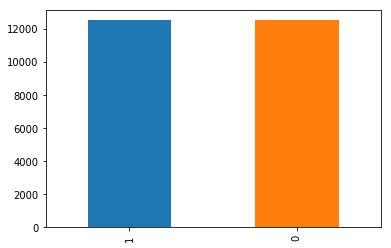

In [6]:
df['category'].value_counts().plot.bar()

# See sample image

In [ ]:
sample = random.choice(filenames)
image = load_img("./train/"+sample)
plt.imshow(image)
print(sample)

# Build Model

In [7]:
from keras.layers import Dropout, Flatten, Dense
from keras import Model, optimizers
from keras.applications import VGG16

img_width, img_height = 224, 224
target_size = (img_width, img_height)

# Load a pre-trained convolutional neural network (CNN) model
model = VGG16(include_top=False, weights="imagenet",
             input_shape = (img_width, img_height, 3))

# Do not retrain feature extraction layers
for layer in model.layers:
    layer.trainable = False

x = model.output
# Extend the pre-trained model
# Flatten the output layer to 1 dimension
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5 to control overfitting
x = Dropout(0.5)(x)
#x = Dense(64, activation='relu')(x)
# Add a final sigmoid layer for classification
predictions = Dense(1, activation='sigmoid')(x)

model_final = Model(input = model.input,
                   output = predictions)

model_final.summary()

58892288/58889256 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [8]:
model_final.compile(loss='binary_crossentropy',
              optimizer='adam',
#              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# Prepare Test and Train Data

In [9]:
# Split training & validation datasets
train_df, validate_df = train_test_split(df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

# Traning Generator

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

batch_size = 1  #16  # No of images per batch
x_col, y_col = 'filename', 'category'
class_mode = 'binary'

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./train/",
    x_col=x_col,
    y_col=y_col,
    class_mode=class_mode,
    target_size=target_size,
    batch_size=batch_size
)

Found 22500 images belonging to 2 classes.


# Validation Generator

In [11]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./train/", 
    x_col=x_col,
    y_col=y_col,
    class_mode=class_mode,
    target_size=target_size,
    batch_size=batch_size
)

Found 2500 images belonging to 2 classes.


# See sample generated images

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary'
)
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Train the Model

In [12]:
# Train the model
epochs = 2
history = model_final.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
#    validation_steps=total_validate//batch_size,
#    steps_per_epoch=total_train//batch_size)
    validation_steps=100,
    steps_per_epoch=1000)

Epoch 1/2
1000/1000 [==============================] - 27s 27ms/step - loss: 4.5665 - acc: 0.6090 - val_loss: 1.6858 - val_acc: 0.7700
Epoch 2/2
1000/1000 [==============================] - 20s 20ms/step - loss: 1.3787 - acc: 0.7400 - val_loss: 0.2429 - val_acc: 0.9100


In [ ]:
loss, accuracy = model_final.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

In [ ]:
def plot_model_history(model_history, acc='acc', val_acc='val_acc'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [21]:
# Save the trained model
model_final.save('my_model.h5')

In [20]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16, decode_predictions

class_names = ( 'cat', 'dog' )
example_df = validate_df.sample(n=100).reset_index(drop=True)
acc = []

for filename in example_df['filename']:
    test_image = image.load_img('./train/'+filename,
                                target_size = (224,224))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
#    test_image.setflags(write=1)
    test_image = preprocess_input(test_image)
    score = model_final.predict(test_image)  #[0]  #[0]
    label = score[0][0]  #decode_predictions(score)[0][0]
    print(filename, label)
    if class_names[int(label)] in filename:
        acc.append(1)
    else:
        acc.append(0)
    print(acc)
    print(np.mean(acc))
    
'''
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16, decode_predictions

model = VGG16()
for filename in df['filename']:
    test_image = image.load_img('./train/'+filename,
                                target_size = (224,224))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
#    test_image.setflags(write=1)
    test_image = preprocess_input(test_image)
    score = model.predict(test_image)  #[0]  #[0]
    label = decode_predictions(score)[0][0]
    print(filename, label[1], label[2])
'''

cat.1513.jpg 0.0
[1]
1.0
cat.3330.jpg 0.0
[1, 1]
1.0
cat.7944.jpg 0.0
[1, 1, 1]
1.0
dog.10719.jpg 1.0
[1, 1, 1, 1]
1.0
dog.8453.jpg 1.0
[1, 1, 1, 1, 1]
1.0
dog.7195.jpg 1.0
[1, 1, 1, 1, 1, 1]
1.0
cat.7271.jpg 0.0
[1, 1, 1, 1, 1, 1, 1]
1.0
cat.8334.jpg 1.0
[1, 1, 1, 1, 1, 1, 1, 0]
0.875
dog.1666.jpg 1.0
[1, 1, 1, 1, 1, 1, 1, 0, 1]
0.8888888888888888
dog.4930.jpg 1.0
[1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
0.9
cat.9608.jpg 0.0
[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]
0.9090909090909091
cat.12208.jpg 0.99999785
[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]
0.9166666666666666
dog.7125.jpg 1.0
[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
0.9230769230769231
cat.2671.jpg 1.0
[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0]
0.8571428571428571
dog.1296.jpg 1.0
[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1]
0.8666666666666667
dog.9044.jpg 1.0
[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1]
0.875
dog.5395.jpg 1.0
[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1]
0.8823529411764706
dog.2806.jpg 1.0
[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1

dog.674.jpg 1.0
[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0.935064935064935
cat.8434.jpg 0.0
[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0.9358974358974359
dog.7265.jpg 1.0
[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0.9367088607594937
cat.3882.jpg 0.0
[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 